## Download and unzip pretrained model, and put into directory pretrained_models

In [1]:
# !pip install gdown
# !gdown https://drive.google.com/u/0/uc?id=1FqwAzeqZcegcskpjr3ZmeA9X-oQxPLmK&export=download    

## Load Model 

In [2]:
import torch
import os
from Source.models.RectificationBaseline import ModelBuilder
model = ModelBuilder(
    arch="ResNet_FPN",
    rec_num_classes=90,
    sDim=256,
    attDim=256,
    max_len_labels=20,
    REC_ON=True,
    FEAT_FUSE=False,
    tps_margins=tuple([0.0, 0.0]),
    STN_ON=True,
)

local_model_path = os.path.join("pretrained_models", "Real_15.pth.tar")

# if torch.cuda.is_available():
#     Pku = Pku.to(torch.device("cuda"))
#     logging.error("gpu is available, switching to CUDA")
#     checkpoint = torch.load(local_model_path)
# else:
#     checkpoint = torch.load(local_model_path, map_location="cpu")
checkpoint = torch.load(local_model_path, map_location="cpu")

model.load_state_dict(checkpoint["state_dict"])

for p in model.parameters():
    p.requires_grad = False
model = model.eval()

## Read Image

In [3]:
from PIL import Image
import numpy as np
import cv2
orig_image = Image.open("imgs/temp.png").convert('RGB')

## Transform Image

In [4]:
image = np.asarray(orig_image)
image = cv2.resize(image, (256, 64)).astype(np.float64)
image = (image - 128.0) / 128.0  # (img - mean) / std. [-1, 1]
image = np.transpose(image, (2, 0, 1))
image = torch.from_numpy(image).float().unsqueeze(0)

In [5]:
output_dict = model.forward(image)

/inferentia/lib/python3.6/site-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/inferentia/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/inferentia/lib/python3.6/site-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [6]:
from Source.evaluation_metrics.metrics import get_str
output = get_str(output_dict)

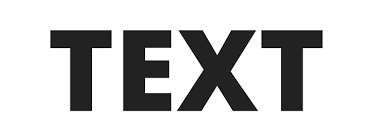

['text']


In [7]:
display(orig_image)
print(output)

In [8]:
import torch
print(torch.__version__)

1.8.1+cu102


In [9]:
import torch_neuron
print(torch_neuron.__version__)

1.8.1.1.4.1.0


In [10]:
image.shape

torch.Size([1, 3, 64, 256])

## Torch neuron analyze

In [11]:
# Analyze the model - this will show operator support and operator count
torch.neuron.analyze_model(model, example_inputs=image)

/home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/Source/models/tps_spatial_transformer.py:119: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert source_control_points.size(1) == self.num_control_points
/home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/Source/models/tps_spatial_transformer.py:120: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert source_control_points.size(2) == 2
INFO:Neuron:The following operations are currently supported in torch-neuron for this model:
INFO:Neuron:aten::batch_norm
INFO:Neuron:aten::ad

OrderedDict([('percent_supported', 99.11653344551956),
             ('percent_supported_arithmetic', 96.00760456273764),
             ('supported_count', 4712),
             ('total_count', 4754),
             ('supported_count_arithmetic', 1010),
             ('total_count_arithmetic', 1052),
             ('supported_operators',
              {'aten::Int',
               'aten::_convolution',
               'aten::add',
               'aten::addmm',
               'aten::batch_norm',
               'aten::bmm',
               'aten::cat',
               'aten::clamp',
               'aten::contiguous',
               'aten::expand',
               'aten::fill_',
               'aten::matmul',
               'aten::max',
               'aten::max_pool2d',
               'aten::mul',
               'aten::relu',
               'aten::sigmoid',
               'aten::size',
               'aten::softmax',
               'aten::squeeze',
               'aten::sub',
               'aten::t'

## Torch neuron trace

In [15]:
model_neuron = torch.neuron.trace(model, example_inputs=image, 
                                  verbose=1,
                                  compiler_workdir='neuron_compile')

/inferentia/lib/python3.6/site-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/inferentia/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/Source/models/tps_spatial_transformer.py:119: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert source_control_points.size(1) == self.num_control_points
/home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/Source/models

INFO:Neuron:PyTorch to TF conversion failed to resolve function on aten::max with inputs [<tf.Tensor 'Softmax:0' shape=(1, 90) dtype=float32>, 1, False]
INFO:Neuron:Exception = Operator translation failed in /inferentia/lib/python3.6/site-packages/torch_neuron/ops/aten.py:855
ERROR:Neuron:Operator translation failed in /inferentia/lib/python3.6/site-packages/torch_neuron/ops/aten.py:855
Traceback (most recent call last):
  File "/inferentia/lib/python3.6/site-packages/torch_neuron/convert.py", line 330, in op_converter
    dynamic_batch_size=self.dynamic_batch_size, **kwargs)
  File "/inferentia/lib/python3.6/site-packages/torch_neuron/decorators.py", line 79, in trace
    transform_torch_graph_to_tensorflow(jit_trace, example_inputs)
  File "/inferentia/lib/python3.6/site-packages/torch_neuron/decorators.py", line 487, in transform_torch_graph_to_tensorflow
    raise e
  File "/inferentia/lib/python3.6/site-packages/torch_neuron/decorators.py", line 481, in transform_torch_graph_to_te

aten::max is not supported in torch-neuron for two tensor variants


INFO:Neuron:Compiling function _NeuronGraph$3823 with neuron-cc
INFO:Neuron:Compiling with command line: '/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/329/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/329/graph_def.neff --io-config {"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2:0": [[1, 256], "float32"]}, "outputs": ["ExpandDims_2:0"]} --verbose 1'
INFO:Neuron:Compile command returned: 120
ERROR:Neuron:neuron-cc failed with the following command line call:
/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/329/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/329/graph_def.neff --io-config '{"inputs": {"tensor.1:0"

aten::max is not supported in torch-neuron for two tensor variants


INFO:Neuron:Compiling function _NeuronGraph$3825 with neuron-cc
INFO:Neuron:Compiling with command line: '/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/333/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/333/graph_def.neff --io-config {"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2:0": [[1, 256], "float32"]}, "outputs": ["ExpandDims_2:0"]} --verbose 1'
INFO:Neuron:Compile command returned: 120
ERROR:Neuron:neuron-cc failed with the following command line call:
/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/333/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/333/graph_def.neff --io-config '{"inputs": {"tensor.1:0"

aten::max is not supported in torch-neuron for two tensor variants


INFO:Neuron:Compile command returned: 120
ERROR:Neuron:neuron-cc failed with the following command line call:
/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/337/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/337/graph_def.neff --io-config '{"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2:0": [[1, 256], "float32"]}, "outputs": ["ExpandDims_2:0"]}' --verbose 1
Traceback (most recent call last):
  File "/inferentia/lib/python3.6/site-packages/torch_neuron/convert.py", line 330, in op_converter
    dynamic_batch_size=self.dynamic_batch_size, **kwargs)
  File "/inferentia/lib/python3.6/site-packages/torch_neuron/decorators.py", line 191, in trace
    'neuron-cc failed with the following command line call:\n{}'.format(command))
subprocess.SubprocessError: neuron-cc failed with the foll

aten::max is not supported in torch-neuron for two tensor variants


INFO:Neuron:Compiling function _NeuronGraph$3829 with neuron-cc
INFO:Neuron:Compiling with command line: '/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/341/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/341/graph_def.neff --io-config {"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2:0": [[1, 256], "float32"]}, "outputs": ["ExpandDims_2:0"]} --verbose 1'
INFO:Neuron:Compile command returned: 120
ERROR:Neuron:neuron-cc failed with the following command line call:
/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/341/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/341/graph_def.neff --io-config '{"inputs": {"tensor.1:0"

aten::max is not supported in torch-neuron for two tensor variants


INFO:Neuron:Compiling function _NeuronGraph$3831 with neuron-cc
INFO:Neuron:Compiling with command line: '/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/345/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/345/graph_def.neff --io-config {"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2:0": [[1, 256], "float32"]}, "outputs": ["ExpandDims_2:0"]} --verbose 1'
INFO:Neuron:Compile command returned: 120
ERROR:Neuron:neuron-cc failed with the following command line call:
/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/345/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/345/graph_def.neff --io-config '{"inputs": {"tensor.1:0"

aten::max is not supported in torch-neuron for two tensor variants


INFO:Neuron:Compiling function _NeuronGraph$3833 with neuron-cc
INFO:Neuron:Compiling with command line: '/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/349/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/349/graph_def.neff --io-config {"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2:0": [[1, 256], "float32"]}, "outputs": ["ExpandDims_2:0"]} --verbose 1'
INFO:Neuron:Compile command returned: 120
ERROR:Neuron:neuron-cc failed with the following command line call:
/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/349/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/349/graph_def.neff --io-config '{"inputs": {"tensor.1:0"

aten::max is not supported in torch-neuron for two tensor variants


INFO:Neuron:Compiling function _NeuronGraph$3835 with neuron-cc
INFO:Neuron:Compiling with command line: '/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/353/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/353/graph_def.neff --io-config {"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2:0": [[1, 256], "float32"]}, "outputs": ["ExpandDims_2:0"]} --verbose 1'
INFO:Neuron:Compile command returned: 120
ERROR:Neuron:neuron-cc failed with the following command line call:
/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/353/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/353/graph_def.neff --io-config '{"inputs": {"tensor.1:0"

aten::max is not supported in torch-neuron for two tensor variants


INFO:Neuron:Compiling function _NeuronGraph$3837 with neuron-cc
INFO:Neuron:Compiling with command line: '/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/357/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/357/graph_def.neff --io-config {"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2:0": [[1, 256], "float32"]}, "outputs": ["ExpandDims_2:0"]} --verbose 1'
INFO:Neuron:Compile command returned: 120
ERROR:Neuron:neuron-cc failed with the following command line call:
/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/357/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/357/graph_def.neff --io-config '{"inputs": {"tensor.1:0"

aten::max is not supported in torch-neuron for two tensor variants


INFO:Neuron:Compile command returned: 120
ERROR:Neuron:neuron-cc failed with the following command line call:
/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/361/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/361/graph_def.neff --io-config '{"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2:0": [[1, 256], "float32"]}, "outputs": ["ExpandDims_2:0"]}' --verbose 1
Traceback (most recent call last):
  File "/inferentia/lib/python3.6/site-packages/torch_neuron/convert.py", line 330, in op_converter
    dynamic_batch_size=self.dynamic_batch_size, **kwargs)
  File "/inferentia/lib/python3.6/site-packages/torch_neuron/decorators.py", line 191, in trace
    'neuron-cc failed with the following command line call:\n{}'.format(command))
subprocess.SubprocessError: neuron-cc failed with the foll

aten::max is not supported in torch-neuron for two tensor variants


INFO:Neuron:Compiling function _NeuronGraph$3841 with neuron-cc
INFO:Neuron:Compiling with command line: '/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/365/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/365/graph_def.neff --io-config {"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2:0": [[1, 256], "float32"]}, "outputs": ["ExpandDims_2:0"]} --verbose 1'
INFO:Neuron:Compile command returned: 120
ERROR:Neuron:neuron-cc failed with the following command line call:
/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/365/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/365/graph_def.neff --io-config '{"inputs": {"tensor.1:0"

aten::max is not supported in torch-neuron for two tensor variants


INFO:Neuron:Compiling function _NeuronGraph$3843 with neuron-cc
INFO:Neuron:Compiling with command line: '/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/369/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/369/graph_def.neff --io-config {"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2:0": [[1, 256], "float32"]}, "outputs": ["ExpandDims_2:0"]} --verbose 1'
INFO:Neuron:Compile command returned: 120
ERROR:Neuron:neuron-cc failed with the following command line call:
/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/369/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/369/graph_def.neff --io-config '{"inputs": {"tensor.1:0"

aten::max is not supported in torch-neuron for two tensor variants


INFO:Neuron:Compile command returned: 120
ERROR:Neuron:neuron-cc failed with the following command line call:
/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/373/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/373/graph_def.neff --io-config '{"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2:0": [[1, 256], "float32"]}, "outputs": ["ExpandDims_2:0"]}' --verbose 1
Traceback (most recent call last):
  File "/inferentia/lib/python3.6/site-packages/torch_neuron/convert.py", line 330, in op_converter
    dynamic_batch_size=self.dynamic_batch_size, **kwargs)
  File "/inferentia/lib/python3.6/site-packages/torch_neuron/decorators.py", line 191, in trace
    'neuron-cc failed with the following command line call:\n{}'.format(command))
subprocess.SubprocessError: neuron-cc failed with the foll

aten::max is not supported in torch-neuron for two tensor variants


INFO:Neuron:Compiling with command line: '/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/377/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/377/graph_def.neff --io-config {"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2:0": [[1, 256], "float32"]}, "outputs": ["ExpandDims_2:0"]} --verbose 1'
INFO:Neuron:Compile command returned: 120
ERROR:Neuron:neuron-cc failed with the following command line call:
/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/377/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/377/graph_def.neff --io-config '{"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2

aten::max is not supported in torch-neuron for two tensor variants


INFO:Neuron:Compiling with command line: '/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/381/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/381/graph_def.neff --io-config {"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2:0": [[1, 256], "float32"]}, "outputs": ["ExpandDims_2:0"]} --verbose 1'
INFO:Neuron:Compile command returned: 120
ERROR:Neuron:neuron-cc failed with the following command line call:
/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/381/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/381/graph_def.neff --io-config '{"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2

aten::max is not supported in torch-neuron for two tensor variants


INFO:Neuron:Compiling with command line: '/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/385/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/385/graph_def.neff --io-config {"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2:0": [[1, 256], "float32"]}, "outputs": ["ExpandDims_2:0"]} --verbose 1'
INFO:Neuron:Compile command returned: 120
ERROR:Neuron:neuron-cc failed with the following command line call:
/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/385/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/385/graph_def.neff --io-config '{"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2

aten::max is not supported in torch-neuron for two tensor variants


INFO:Neuron:Compiling function _NeuronGraph$3853 with neuron-cc
INFO:Neuron:Compiling with command line: '/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/389/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/389/graph_def.neff --io-config {"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2:0": [[1, 256], "float32"]}, "outputs": ["ExpandDims_2:0"]} --verbose 1'
INFO:Neuron:Compile command returned: 120
ERROR:Neuron:neuron-cc failed with the following command line call:
/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/389/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/389/graph_def.neff --io-config '{"inputs": {"tensor.1:0"

aten::max is not supported in torch-neuron for two tensor variants


INFO:Neuron:Compiling with command line: '/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/393/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/393/graph_def.neff --io-config {"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2:0": [[1, 256], "float32"]}, "outputs": ["ExpandDims_2:0"]} --verbose 1'
INFO:Neuron:Compile command returned: 120
ERROR:Neuron:neuron-cc failed with the following command line call:
/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/393/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/393/graph_def.neff --io-config '{"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2

aten::max is not supported in torch-neuron for two tensor variants


INFO:Neuron:Compile command returned: 120
ERROR:Neuron:neuron-cc failed with the following command line call:
/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/397/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/397/graph_def.neff --io-config '{"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2:0": [[1, 256], "float32"]}, "outputs": ["ExpandDims_2:0"]}' --verbose 1
Traceback (most recent call last):
  File "/inferentia/lib/python3.6/site-packages/torch_neuron/convert.py", line 330, in op_converter
    dynamic_batch_size=self.dynamic_batch_size, **kwargs)
  File "/inferentia/lib/python3.6/site-packages/torch_neuron/decorators.py", line 191, in trace
    'neuron-cc failed with the following command line call:\n{}'.format(command))
subprocess.SubprocessError: neuron-cc failed with the foll

aten::max is not supported in torch-neuron for two tensor variants


INFO:Neuron:Compiling function _NeuronGraph$3859 with neuron-cc
INFO:Neuron:Compiling with command line: '/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/401/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/401/graph_def.neff --io-config {"inputs": {"tensor.1:0": [[1, 31, 512], "float32"], "1:0": [[1, 1, 256], "float32"], "2:0": [[1, 256], "float32"]}, "outputs": ["ExpandDims_2:0"]} --verbose 1'
INFO:Neuron:Compile command returned: 120
ERROR:Neuron:neuron-cc failed with the following command line call:
/inferentia/bin/neuron-cc compile /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/401/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /home/DATA/raghav/inferentia/ICDAR2019-ArT-Recognition-Alchemy/neuron_compile/401/graph_def.neff --io-config '{"inputs": {"tensor.1:0"

TypeError: softmax() received an invalid combination of arguments - got (dtype=NoneType, input=tuple, dim=int, ), but expected one of:
 * (Tensor input, name dim, *, torch.dtype dtype)
 * (Tensor input, int dim, torch.dtype dtype)
      didn't match because some of the arguments have invalid types: (!input=tuple!, dim=int, !dtype=NoneType!, )
